In [1]:
# %load ../titanic/mlpack.py
#Suppress Warninings
import warnings
import requests 
import json
from dask import delayed, compute
import dask
from xml.etree import ElementTree
from matplotlib import pyplot as plt
# %matplotlib notebook

from scipy.stats import zscore
import collections

from dask.diagnostics import ProgressBar
ProgressBar().register()

warnings.filterwarnings('ignore')

#Simpled desiged function to give a birds eye look into the dataset.

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
import seaborn as sb

from sklearn import model_selection
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score,r2_score,classification_report, roc_auc_score
from sklearn.preprocessing import LabelEncoder,OneHotEncoder, StandardScaler, Normalizer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold,StratifiedKFold, cross_val_score
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier,AdaBoostClassifier,ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE

def read_basic(name=None):
    if(name==None):
        raise ValueError('No File Name provided')
        return 0
    print('-------------------{}----------------'.format(name))
    df = pd.read_csv(name)
    print('Datatypes: \n', df.dtypes)
    print('-----------------------------\n')
    print('Dimension: \n', df.shape)
    print('-----------------------------\n')
    print('Missing values per column: \n', df.isna().sum())
    print('-----------------------------\n')
    print('Dataframe Info: \n', df.info())
    print('-----------------------------\n')
    print('Descriptive Stats: \n', df.describe())

    return df# %load mlpack.py


# AS per the second dataset on Kaggle, the block code information can be obtained using the API:
# https://geo.fcc.gov/api/census/#!/block/get_block_find. We use this to find the appropraiate block code
# for all lat,long pairs in the NYC dataset.
# @delayed
# def fips_code(lat, long):
#     url = 'https://geo.fcc.gov/api/census/block/find?latitude={}&longitude={}&format=json'.format(lat,long)
#     r = str(requests.get(url = url).content)
# #     print(r)
# #     print(r.find('FIPS'))
#     return np.int(r[r.find('FIPS')+7:r.find("bbox")-3])
# #     msg = r.content.decode()
# #     return np.int(json.loads(msg)['Block']['FIPS'])


#THis task took around 2 hours, so I have saved the result to re-use in a .npy format
def fips_code(lng, lat): 
    '''Returns census block code given longitude and latitude.'''
    params = {'longitude': str(lng), 'latitude': str(lat)}
    r = requests.get("http://data.fcc.gov/api/block/2010/find", params=params)
    tree = ElementTree.fromstring(r.content)

    for child in tree.iter('{http://data.fcc.gov/api}Block'):
        return child.attrib['FIPS']


c:\python36\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [2]:
#Basic read csv file to data frames

nyc_foursquare_df = read_basic('dataset_TSMC2014_NYC.csv')
nyc_foursquare_df['CensusTract'] = np.load('block_code_nyc.npy')
nyc_foursquare_df.CensusTract = nyc_foursquare_df.CensusTract.apply(lambda x: str(x)[:11])
nyc_foursquare_df.head()

-------------------dataset_TSMC2014_NYC.csv----------------
Datatypes: 
 userId               int64
venueId             object
venueCategoryId     object
venueCategory       object
latitude           float64
longitude          float64
timezoneOffset       int64
utcTimestamp        object
dtype: object
-----------------------------

Dimension: 
 (227428, 8)
-----------------------------

Missing values per column: 
 userId             0
venueId            0
venueCategoryId    0
venueCategory      0
latitude           0
longitude          0
timezoneOffset     0
utcTimestamp       0
dtype: int64
-----------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227428 entries, 0 to 227427
Data columns (total 8 columns):
userId             227428 non-null int64
venueId            227428 non-null object
venueCategoryId    227428 non-null object
venueCategory      227428 non-null object
latitude           227428 non-null float64
longitude          227428 non-null float64
timezo

,userId,venueId,venueCategoryId,venueCategory,latitude,longitude,timezoneOffset,utcTimestamp,CensusTract
0,470,49bbd6c0f964a520f4531fe3,4bf58dd8d48988d127951735,Arts & Crafts Store,40.719810,-74.002581,-240,Tue Apr 03 18:00:09 +0000 2012,36061003300
1,979,4a43c0aef964a520c6a61fe3,4bf58dd8d48988d1df941735,Bridge,40.606800,-74.044170,-240,Tue Apr 03 18:00:25 +0000 2012,36085001800
2,69,4c5cc7b485a1e21e00d35711,4bf58dd8d48988d103941735,Home (private),40.716162,-73.883070,-240,Tue Apr 03 18:02:24 +0000 2012,36081065900
3,395,4bc7086715a7ef3bef9878da,4bf58dd8d48988d104941735,Medical Center,40.745164,-73.982519,-240,Tue Apr 03 18:02:41 +0000 2012,36061007200
4,87,4cf2c5321d18a143951b5cec,4bf58dd8d48988d1cb941735,Food Truck,40.740104,-73.989658,-240,Tue Apr 03 18:03:00 +0000 2012,36061005600


## Read and process source data into pandas dataframe

In [3]:
#1.	Import NYC check-in dataset(dataset_TSMC2014_NYC.csv) into python
nyc_census_checkin_df = nyc_foursquare_df[['latitude', 'longitude', 'CensusTract']]

# 2.	Convert Coordinates in the dataset to census tracts and output the file to census_tracts_per_checkin.csv
# 3.	Add a census tract column to the census_tracts_per_checkin.csv file. Make sure this column is the same as the dataset_TSMC2014_NYC.csv file
nyc_census_checkin_df.to_csv('census_tracts_per_checkin.csv')

In [4]:
# 4.	Import NYC census dataset into python(nyc_census_tracts.csv)
nyc_census_tracts_df = read_basic('nyc_census_tracts.csv')

-------------------nyc_census_tracts.csv----------------
Datatypes: 
 CensusTract          int64
County              object
Borough             object
TotalPop             int64
Men                  int64
Women                int64
Hispanic           float64
White              float64
Black              float64
Native             float64
Asian              float64
Citizen              int64
Income             float64
IncomeErr          float64
IncomePerCap       float64
IncomePerCapErr    float64
Poverty            float64
ChildPoverty       float64
Professional       float64
Service            float64
Office             float64
Construction       float64
Production         float64
Drive              float64
Carpool            float64
Transit            float64
Walk               float64
OtherTransp        float64
WorkAtHome         float64
MeanCommute        float64
Employed             int64
PrivateWork        float64
PublicWork         float64
SelfEmployed       float64
FamilyWork  

In [5]:
# 5.	Create a dataset from 4 that excludes all null values of the income variable from nyc_census_tracts.csv and 
nyc_census_tracts_df = nyc_census_tracts_df[~nyc_census_tracts_df.Income.isna()]
print('Shape of Census Tract dataset: ',  nyc_census_tracts_df.shape)
nyc_census_tracts_df.isna().sum()

Shape of Census Tract dataset:  (2101, 36)


CensusTract        0
County             0
Borough            0
TotalPop           0
Men                0
Women              0
Hispanic           0
White              0
Black              0
Native             0
Asian              0
Citizen            0
Income             0
IncomeErr          0
IncomePerCap       0
IncomePerCapErr    0
Poverty            0
ChildPoverty       4
Professional       0
Service            0
Office             0
Construction       0
Production         0
Drive              0
Carpool            0
Transit            0
Walk               0
OtherTransp        0
WorkAtHome         0
MeanCommute        3
Employed           0
PrivateWork        0
PublicWork         0
SelfEmployed       0
FamilyWork         0
Unemployment       0
dtype: int64

In [6]:
# 6.	Create a separate dataset consisting of the census_tract column alone
census_tract_only_df = nyc_census_checkin_df[['CensusTract']]
census_tract_only_df.info()

# 7.	Calculate the total number of checkins per census tract and include it as a separate column in 6
check_in_counts = collections.Counter(census_tract_only_df.CensusTract.values)
census_tract_only_df['num_checkins'] = census_tract_only_df.CensusTract.apply(lambda x: check_in_counts[x])
census_tract_only_df.CensusTract = census_tract_only_df.CensusTract.apply(np.int)
census_tract_only_df.info()
census_tract_only_df.head()

#It is a good idea to drop duplicates
# print()
census_tract_only_df = census_tract_only_df.drop_duplicates()
census_tract_only_df.info()
census_tract_only_df.head()
# census_tract_only_df.num_checkins.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227428 entries, 0 to 227427
Data columns (total 1 columns):
CensusTract    227428 non-null object
dtypes: object(1)
memory usage: 1.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227428 entries, 0 to 227427
Data columns (total 2 columns):
CensusTract     227428 non-null int64
num_checkins    227428 non-null int64
dtypes: int64(2)
memory usage: 3.5 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2612 entries, 0 to 226898
Data columns (total 2 columns):
CensusTract     2612 non-null int64
num_checkins    2612 non-null int64
dtypes: int64(2)
memory usage: 61.2 KB


,CensusTract,num_checkins
0,36061003300,745
1,36085001800,175
2,36081065900,112
3,36061007200,1747
4,36061005600,2345


In [7]:
# 8.	Merge datasets created in 5 and 7
print('SHapes before merge: ', nyc_census_tracts_df.shape, census_tract_only_df.shape )
nyc_merge_census_tract_df = nyc_census_tracts_df.merge(census_tract_only_df, on='CensusTract', how='inner')
print('Shape of merge dataset: ',nyc_merge_census_tract_df.shape)
nyc_merge_census_tract_df.head()

SHapes before merge:  (2101, 36) (2612, 2)
Shape of merge dataset:  (1881, 37)


,CensusTract,County,Borough,TotalPop,Men,Women,Hispanic,White,Black,Native,...,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment,num_checkins
0,36005000200,Bronx,Bronx,5403,2659,2744,75.8,2.3,16.0,0.0,...,0.0,0.0,43.0,2308,80.8,16.2,2.9,0.0,7.7,1
1,36005000400,Bronx,Bronx,5915,2896,3019,62.7,3.6,30.7,0.0,...,0.5,2.1,45.0,2675,71.7,25.3,2.5,0.6,9.5,1
2,36005001600,Bronx,Bronx,5879,2558,3321,65.1,1.6,32.4,0.0,...,1.6,1.7,38.8,2120,75.0,21.3,3.8,0.0,8.7,76
3,36005001900,Bronx,Bronx,2591,1206,1385,55.4,9.0,29.0,0.0,...,2.4,6.2,45.4,1083,76.8,15.5,7.7,0.0,19.2,77
4,36005002000,Bronx,Bronx,8516,3301,5215,61.1,1.6,31.1,0.3,...,1.0,0.0,46.0,2508,71.0,21.3,7.7,0.0,17.2,4


In [8]:
nyc_merge_census_tract_df.isna().sum()

CensusTract        0
County             0
Borough            0
TotalPop           0
Men                0
Women              0
Hispanic           0
White              0
Black              0
Native             0
Asian              0
Citizen            0
Income             0
IncomeErr          0
IncomePerCap       0
IncomePerCapErr    0
Poverty            0
ChildPoverty       3
Professional       0
Service            0
Office             0
Construction       0
Production         0
Drive              0
Carpool            0
Transit            0
Walk               0
OtherTransp        0
WorkAtHome         0
MeanCommute        3
Employed           0
PrivateWork        0
PublicWork         0
SelfEmployed       0
FamilyWork         0
Unemployment       0
num_checkins       0
dtype: int64

In [9]:
# 9.	Remove census_tract, county and borough columns from the merged dataset in 8
nyc_merge_census_tract_df.drop(['CensusTract','Borough','County'], axis=1, inplace=True)

In [10]:
nyc_merge_census_tract_df = nyc_merge_census_tract_df.reindex()
# nyc_merge_census_tract_df.info()

In [11]:
nyc_merge_census_tract_df['Z_num_checkins'] = zscore(nyc_merge_census_tract_df.num_checkins.values)

In [12]:
# 10. Eliminate outliers from the num_checkins column 
#Lets consider those that lie 3 standard deviations away from mean as outliers.
nyc_merge_census_tract_df = nyc_merge_census_tract_df[abs(nyc_merge_census_tract_df.Z_num_checkins)<3]
# nyc_merge_census_tract_df.info()
nyc_merge_census_tract_df.isna().sum()
nyc_merge_census_tract_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1839 entries, 0 to 1880
Data columns (total 35 columns):
TotalPop           1839 non-null int64
Men                1839 non-null int64
Women              1839 non-null int64
Hispanic           1839 non-null float64
White              1839 non-null float64
Black              1839 non-null float64
Native             1839 non-null float64
Asian              1839 non-null float64
Citizen            1839 non-null int64
Income             1839 non-null float64
IncomeErr          1839 non-null float64
IncomePerCap       1839 non-null float64
IncomePerCapErr    1839 non-null float64
Poverty            1839 non-null float64
ChildPoverty       1838 non-null float64
Professional       1839 non-null float64
Service            1839 non-null float64
Office             1839 non-null float64
Construction       1839 non-null float64
Production         1839 non-null float64
Drive              1839 non-null float64
Carpool            1839 non-null float64

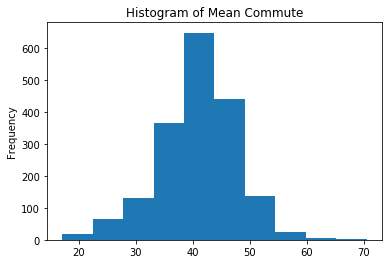

In [13]:
nyc_merge_census_tract_df.MeanCommute.plot(kind='hist', title='Histogram of Mean Commute')

In [14]:
# 11.	Impute or remove missing values as you deem fit

#We observe 1 missing value for ChildPoverty and 3 missing values for MeanCOmmute
#Impute ChildPoverty with 0, as 0 percent is the mode
#Impute expcted value=mean of MeanCommute field as its roughly follows a normal distribution
nyc_merge_census_tract_df.ChildPoverty.fillna(0, inplace=True)
nyc_merge_census_tract_df.drop(['Z_num_checkins'], axis=1, inplace=True)
nyc_merge_census_tract_df.MeanCommute.fillna(nyc_merge_census_tract_df.MeanCommute.mean(), inplace=True)

In [15]:

nyc_merge_census_tract_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1839 entries, 0 to 1880
Data columns (total 34 columns):
TotalPop           1839 non-null int64
Men                1839 non-null int64
Women              1839 non-null int64
Hispanic           1839 non-null float64
White              1839 non-null float64
Black              1839 non-null float64
Native             1839 non-null float64
Asian              1839 non-null float64
Citizen            1839 non-null int64
Income             1839 non-null float64
IncomeErr          1839 non-null float64
IncomePerCap       1839 non-null float64
IncomePerCapErr    1839 non-null float64
Poverty            1839 non-null float64
ChildPoverty       1839 non-null float64
Professional       1839 non-null float64
Service            1839 non-null float64
Office             1839 non-null float64
Construction       1839 non-null float64
Production         1839 non-null float64
Drive              1839 non-null float64
Carpool            1839 non-null float64

In [16]:
# 13.	Split the dataset into dependent and independent variables, with the dependent variable being total number of check-ins

nyc_census_X = nyc_merge_census_tract_df.drop(['num_checkins'],axis=1)
nyc_census_Y = nyc_merge_census_tract_df['num_checkins']

In [17]:
nyc_census_Y.shape

(1839,)

In [18]:
# 14.	Do min-max scaling on the independent variables
from sklearn.preprocessing import MinMaxScaler

def scale_min_max(series):
    scaler_ = MinMaxScaler()
    return scaler_.fit_transform(series.values.reshape(-1,1))

In [19]:
import seaborn as sb
for col in nyc_census_X.columns:
    nyc_census_X[col] = scale_min_max(nyc_census_X[col])
# print(min(nyc_census_Y), max(nyc_census_Y))
nyc_census_X.head()


,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Citizen,Income,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,0.185971,0.196593,0.176729,0.792887,0.023092,0.160,0.000000,0.046771,0.157807,0.265214,...,0.048253,0.000000,0.000000,0.485019,0.180017,0.629344,0.406015,0.124464,0.000000,0.122807
1,0.203689,0.214222,0.194525,0.655858,0.036145,0.307,0.000000,0.003341,0.177959,0.277161,...,0.023295,0.008993,0.047297,0.522472,0.208754,0.453668,0.634085,0.107296,0.153846,0.151515
2,0.202443,0.189081,0.214068,0.680962,0.016064,0.324,0.000000,0.000000,0.153305,0.095858,...,0.143095,0.028777,0.038288,0.406367,0.165296,0.517375,0.533835,0.163090,0.000000,0.138756
3,0.088660,0.088515,0.088785,0.579498,0.090361,0.290,0.000000,0.023385,0.066795,0.119836,...,0.049917,0.043165,0.139640,0.529963,0.084097,0.552124,0.388471,0.330472,0.000000,0.306220
4,0.293698,0.244347,0.336634,0.639121,0.016064,0.311,0.026549,0.036748,0.236361,0.035204,...,0.071547,0.017986,0.000000,0.541199,0.195678,0.440154,0.533835,0.330472,0.000000,0.274322


In [20]:
# nyc_census_Y.reshape(1,-1)[0]

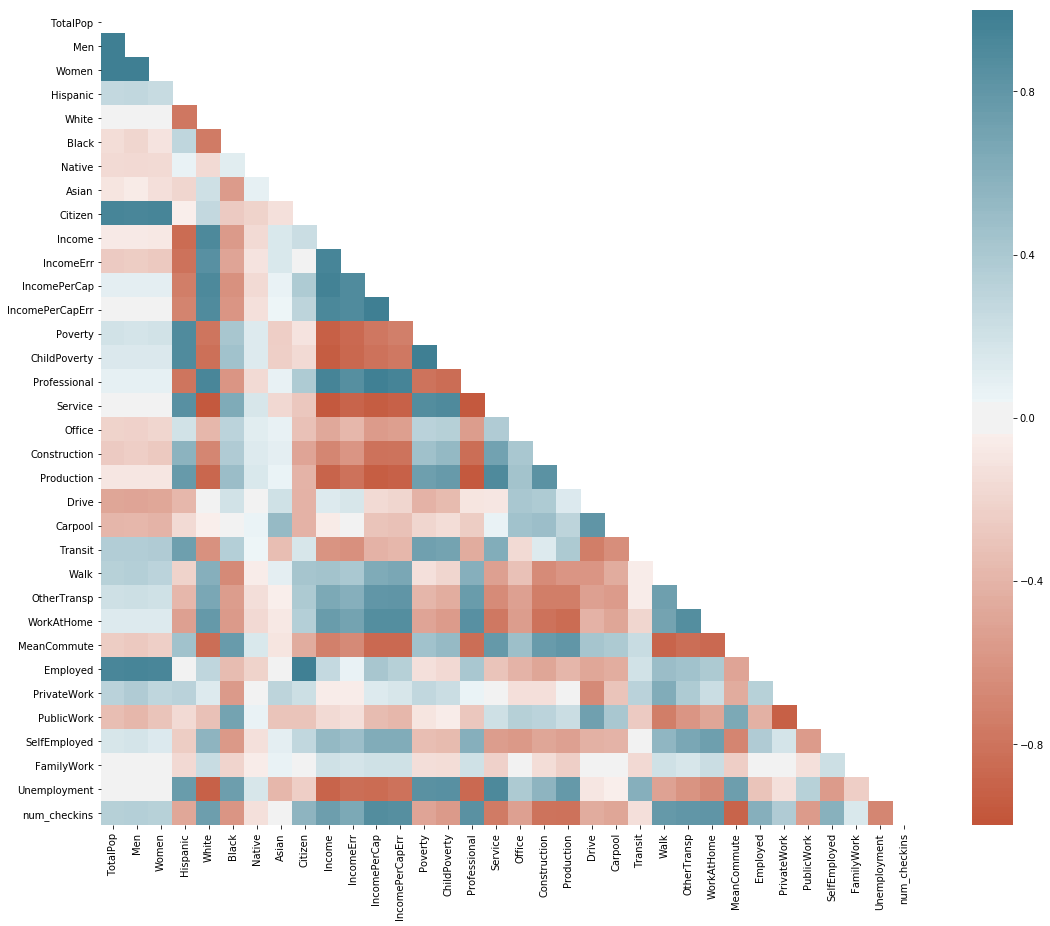

In [21]:
plt.figure(figsize=(20,15))
# Generate a mask for the upper triangle

# correlation heatmap of dataset
def correlation_heatmap(df):
    return df.corr()

# 12.	Construct a correlogram of all the variables, output the correlation values to an external excel file
nyc_merge_census_corr = correlation_heatmap(nyc_merge_census_tract_df)
nyc_merge_census_corr.to_csv('nyc_pearson_correlation.csv')
nyc_merge_census_corr.columns

mask = np.zeros_like(nyc_merge_census_corr.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sb.heatmap(nyc_merge_census_corr.corr(), mask=mask, vmin=-1, vmax=1, center=0, cmap=sb.diverging_palette(20, 220, n=200),square=True)

In [22]:
# plt.figure(figsize=(20,18))
# sb.heatmap(nyc_census_X.corr())

In [23]:
# nyc_census_X = nyc_census_X[['MeanCommute', 'Income', 'Walk', 'PublicWork', 'Drive',
#        'Carpool']]

In [24]:
# 15.	Fit an extra-trees model of the data and display the relative importance of the features
MLA = [
    #Ensemble Methods
    ExtraTreesRegressor()]

In [25]:
nyc_census_X_train, nyc_census_X_test, nyc_census_Y_train, nyc_census_Y_test =  train_test_split(nyc_census_X, nyc_census_Y, test_size=0.3, random_state=0)

In [26]:
# nyc_census_Y_test.isna().sum()

def mean_squared_error(y, y_pred):
# assuming y and y_pred are numpy arrays
#     print(type(y), type(y_pred))
    return np.mean(np.sqrt(np.sum(np.power(y - y_pred, 2))))

In [27]:
#create table to compare MLA metrics
def perform_algorithm_analysis(MLA):
    from sklearn.metrics import make_scorer
    my_scorer = make_scorer(mean_squared_error, greater_is_better=False)
    
    
    MLA_columns = ['MLA Name', 'MLA Parameters', 'MLA Train Accuracy Mean','MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD' ,'MLA Time']
    MLA_compare = pd.DataFrame(columns = MLA_columns)

    #create table to compare MLA predictions
    MLA_predict = pd.DataFrame()
    
    #5-fold cross validation
    cv_split = model_selection.ShuffleSplit(n_splits = 5, random_state = 0 ) 
    
    #index through MLA and save performance to table
    row_index = 0
    for alg in MLA:

        #set name and parameters
        MLA_name = alg.__class__.__name__
        MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
        MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())

        #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
        cv_results = model_selection.cross_validate(alg, nyc_census_X_train, nyc_census_Y_train, cv  = cv_split, scoring='explained_variance', return_train_score=True)
    #     print(cv_results)
        MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
        MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
        MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()   
        #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
        MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3   #let's know the worst that can happen!

        #save MLA predictions - see section 6 for usage
        alg.fit(nyc_census_X_train, nyc_census_Y_train)
        row_index+=1
        MLA_predict[MLA_name] = alg.predict(nyc_census_X_test)

    #print and sort table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html
    MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
    return MLA, MLA_compare, MLA_predict

In [28]:
MLA, MLA_compare, MLA_predict = perform_algorithm_analysis(MLA)

model = MLA[0]
scores_ = model.feature_importances_
feat = nyc_census_X.columns

list_ = sorted([(y,x) for x,y in zip(feat, scores_)], reverse=True)
top_importance = [y for x,y in list_]
print(list_)
# plt.bar(feat, scores_)


[(0.18401995205019808, 'IncomePerCap'), (0.14199974831493334, 'MeanCommute'), (0.06344422509397077, 'Income'), (0.045233868991687756, 'Walk'), (0.03570258009594049, 'Production'), (0.03305733064967185, 'Professional'), (0.0321190713966549, 'Drive'), (0.032031214507847364, 'PublicWork'), (0.02982584237045608, 'Employed'), (0.027887035157585373, 'Carpool'), (0.023367266204898963, 'Asian'), (0.0219963334253457, 'Office'), (0.021016955202758165, 'PrivateWork'), (0.020902324796795588, 'TotalPop'), (0.019711783518956104, 'FamilyWork'), (0.019539483550881996, 'Citizen'), (0.01909497265787598, 'WorkAtHome'), (0.018857577568519465, 'IncomeErr'), (0.017249337691070253, 'IncomePerCapErr'), (0.015990465015846927, 'Native'), (0.01590926615788957, 'Men'), (0.015627615077319287, 'Construction'), (0.015259986675859049, 'OtherTransp'), (0.0150955982765898, 'ChildPoverty'), (0.014632583689478168, 'Poverty'), (0.01458455422160213, 'Service'), (0.01450227111590129, 'Black'), (0.014435753743239415, 'Women'

<BarContainer object of 33 artists>

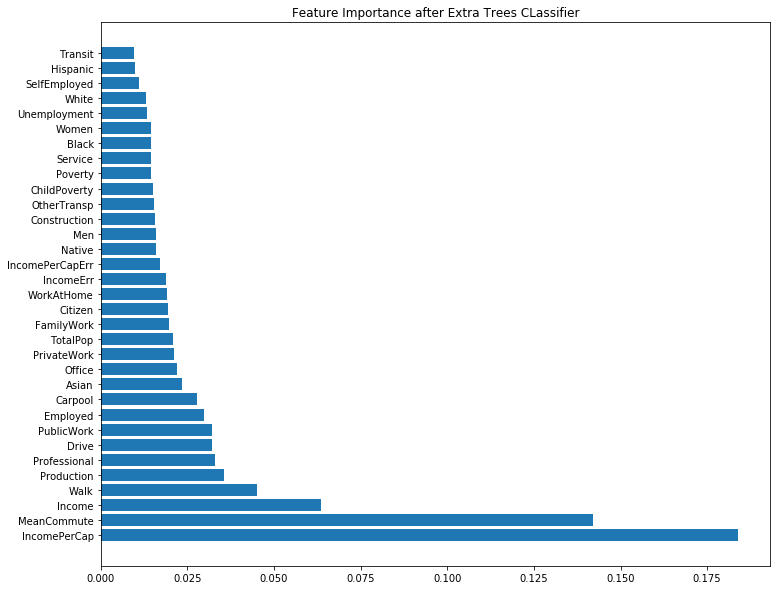

In [29]:
plt.figure(figsize=(12,10))
plt.title('Feature Importance after Extra Trees CLassifier')
plt.barh([x[1] for x in list_], [x[0] for x in list_])
# plt.show()

In [30]:
#Machine Learning Algorithm (MLA) Selection and Initialization
# 20.	Fit SVR, linear SVR, gradient boosting, ada-boost, SGD-regressor, lasso and elastic net models 
# on the dataset and measure the cross-validation accuracy scores

from sklearn import ensemble, linear_model, naive_bayes, svm, tree, discriminant_analysis, gaussian_process, neighbors
from sklearn import model_selection
from xgboost import XGBClassifier, XGBRegressor

MLA = [
    #Ensemble Methods
    ensemble.AdaBoostRegressor(n_estimators=100, loss='exponential'),
    ensemble.ExtraTreesRegressor(),
    ensemble.GradientBoostingRegressor(n_estimators=100),
    ensemble.RandomForestRegressor(),

    #GLM
    linear_model.LinearRegression(),
    linear_model.SGDRegressor(),
    linear_model.Ridge(),
    linear_model.Lasso(),
    
    #SVM
    svm.SVR(),
    svm.LinearSVR(),
    
    #
    ]

In [31]:
np.array(top_importance[0:15])

array(['IncomePerCap', 'MeanCommute', 'Income', 'Walk', 'Production',
       'Professional', 'Drive', 'PublicWork', 'Employed', 'Carpool',
       'Asian', 'Office', 'PrivateWork', 'TotalPop', 'FamilyWork'],
      dtype='<U12')

In [32]:
print(top_importance[0:15])
nyc_census_X[top_importance[0:15]].corr()

['IncomePerCap', 'MeanCommute', 'Income', 'Walk', 'Production', 'Professional', 'Drive', 'PublicWork', 'Employed', 'Carpool', 'Asian', 'Office', 'PrivateWork', 'TotalPop', 'FamilyWork']


,IncomePerCap,MeanCommute,Income,Walk,Production,Professional,Drive,PublicWork,Employed,Carpool,Asian,Office,PrivateWork,TotalPop,FamilyWork
IncomePerCap,1.000000,-0.520037,0.837821,0.331038,-0.570986,0.775586,-0.147046,-0.195143,0.299310,-0.191032,-0.034862,-0.251206,0.063769,0.073867,0.076150
MeanCommute,-0.520037,1.000000,-0.351475,-0.625805,0.374016,-0.510768,0.290222,0.404880,-0.236654,0.167688,0.010371,0.111779,-0.266813,-0.128012,-0.083852
Income,0.837821,-0.351475,1.000000,0.100559,-0.503534,0.740439,0.167108,-0.026746,0.167317,-0.003084,0.044245,-0.226778,-0.076415,-0.077025,0.054257
Walk,0.331038,-0.625805,0.100559,1.000000,-0.220939,0.265286,-0.441198,-0.416327,0.189970,-0.170948,0.045726,-0.005866,0.364602,0.179626,0.075294
Production,-0.570986,0.374016,-0.503534,-0.220939,1.000000,-0.714488,0.105985,0.005978,-0.173315,0.170128,0.129993,0.053389,0.039196,-0.028890,-0.083962
Professional,0.775586,-0.510768,0.740439,0.265286,-0.714488,1.000000,-0.090118,-0.076133,0.246671,-0.162348,-0.020957,-0.346961,-0.049226,0.026906,0.038078
Drive,-0.147046,0.290222,0.167108,-0.441198,0.105985,-0.090118,1.000000,0.505136,-0.279157,0.483178,0.079761,0.232760,-0.403166,-0.257038,0.000018
PublicWork,-0.195143,0.404880,-0.026746,-0.416327,0.005978,-0.076133,0.505136,1.000000,-0.226791,0.144713,-0.253280,0.094490,-0.862524,-0.168599,-0.058891
Employed,0.299310,-0.236654,0.167317,0.189970,-0.173315,0.246671,-0.279157,-0.226791,1.000000,-0.178743,0.014298,-0.160058,0.160108,0.916922,0.013375
Carpool,-0.191032,0.167688,-0.003084,-0.170948,0.170128,-0.162348,0.483178,0.144713,-0.178743,1.000000,0.333426,0.164417,-0.072845,-0.132463,0.006595


In [33]:
#We remove the most correlated feature, where correlation is more than +/- 0.8
# 16.	Eliminate unimportant features
top_importance = ['MeanCommute', 'Walk', 'Income', 'Service', 'Drive', 'PrivateWork', 'Construction', 'OtherTransp', 'Employed']

In [34]:
#Looking at the correlations, we are good with the selected featured for our prediction
nyc_census_X[top_importance].corr()

,MeanCommute,Walk,Income,Service,Drive,PrivateWork,Construction,OtherTransp,Employed
MeanCommute,1.000000,-0.625805,-0.351475,0.449031,0.290222,-0.266813,0.317732,-0.356663,-0.236654
Walk,-0.625805,1.000000,0.100559,-0.212588,-0.441198,0.364602,-0.260724,0.268398,0.189970
Income,-0.351475,0.100559,1.000000,-0.703251,0.167108,-0.076415,-0.278875,0.274909,0.167317
Service,0.449031,-0.212588,-0.703251,1.000000,-0.130751,0.052261,0.294771,-0.223624,-0.150398
Drive,0.290222,-0.441198,0.167108,-0.130751,1.000000,-0.403166,0.258484,-0.368879,-0.279157
PrivateWork,-0.266813,0.364602,-0.076415,0.052261,-0.403166,1.000000,0.002933,0.183260,0.160108
Construction,0.317732,-0.260724,-0.278875,0.294771,0.258484,0.002933,1.000000,-0.239983,-0.186952
OtherTransp,-0.356663,0.268398,0.274909,-0.223624,-0.368879,0.183260,-0.239983,1.000000,0.198317
Employed,-0.236654,0.189970,0.167317,-0.150398,-0.279157,0.160108,-0.186952,0.198317,1.000000


In [35]:
nyc_census_X = nyc_census_X[top_importance]

In [36]:
max_vals = list()
# for x in range(1,len(top_importance)):
selected_features = top_importance[0:]
# print(selected_features)
nyc_census_X_ = nyc_census_X[selected_features]
nyc_census_X_train, nyc_census_X_test, nyc_census_Y_train, nyc_census_Y_test =  train_test_split(nyc_census_X_, nyc_census_Y, test_size=0.3, random_state=0)
MLA, MLA_compare, MLA_predict = perform_algorithm_analysis(MLA)
# max_vals.append(MLA_compare['MLA Test Explained Variance'].max())

In [37]:
MLA_compare

,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
2,GradientBoostingRegressor,"{'alpha': 0.9, 'criterion': 'friedman_mse', 'i...",0.815009,0.324085,0.294226,0.061227
0,AdaBoostRegressor,"{'base_estimator': None, 'learning_rate': 1.0,...",0.599537,0.305404,0.276663,0.172754
7,Lasso,"{'alpha': 1.0, 'copy_X': True, 'fit_intercept'...",0.383788,0.299968,0.17188,0.00200019
6,Ridge,"{'alpha': 1.0, 'copy_X': True, 'fit_intercept'...",0.397941,0.299208,0.194081,0.00159211
5,SGDRegressor,"{'alpha': 0.0001, 'average': False, 'early_sto...",0.391,0.295441,0.206492,0.0183704
4,LinearRegression,"{'copy_X': True, 'fit_intercept': True, 'n_job...",0.398604,0.293668,0.200917,0.00159807
3,RandomForestRegressor,"{'bootstrap': True, 'criterion': 'mse', 'max_d...",0.894566,0.231511,0.374355,0.0580472
1,ExtraTreesRegressor,"{'bootstrap': False, 'criterion': 'mse', 'max_...",1,0.216805,0.452601,0.0281341
9,LinearSVR,"{'C': 1.0, 'dual': True, 'epsilon': 0.0, 'fit_...",0.127104,0.120921,0.0307277,0.00159702
8,SVR,"{'C': 1.0, 'cache_size': 200, 'coef0': 0.0, 'd...",0.0487963,0.0472719,0.0079168,0.044869


In [38]:
import statsmodels.api as sm
# from pandas.stats.api import ols

In [39]:
#Fitting Ordinary least squares
# 17.	Fit a Regression model and further eliminate any unnecessary features
model_ols = sm.OLS(nyc_census_Y_train, nyc_census_X_train)
# model = sm.OLS(y, X)
results = model_ols.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:           num_checkins   R-squared (uncentered):                   0.531
Model:                            OLS   Adj. R-squared (uncentered):              0.528
Method:                 Least Squares   F-statistic:                              160.9
Date:                Fri, 28 Jun 2019   Prob (F-statistic):                   3.84e-203
Time:                        21:22:04   Log-Likelihood:                         -7658.8
No. Observations:                1287   AIC:                                  1.534e+04
Df Residuals:                    1278   BIC:                                  1.538e+04
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

In [40]:
#Removig the predictors since the p-value>0.05
nyc_census_X.drop(['OtherTransp'], axis=1, inplace=True)
nyc_census_X.drop(['Service'], axis=1, inplace=True)
# nyc_census_X.drop(['IncomePerCap'], axis=1, inplace=True)

In [41]:
# 18.	Split the dataset into training and testing
nyc_census_X_train, nyc_census_X_test, nyc_census_Y_train, nyc_census_Y_test =  train_test_split(nyc_census_X, nyc_census_Y, test_size=0.3, random_state=0)

In [42]:
# 19.	Do cross-validation
MLA, MLA_compare, MLA_predict = perform_algorithm_analysis(MLA)
MLA_compare

,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
2,GradientBoostingRegressor,"{'alpha': 0.9, 'criterion': 'friedman_mse', 'i...",0.805723,0.327057,0.324235,0.048676
0,AdaBoostRegressor,"{'base_estimator': None, 'learning_rate': 1.0,...",0.575413,0.306752,0.297855,0.145829
6,Ridge,"{'alpha': 1.0, 'copy_X': True, 'fit_intercept'...",0.397281,0.29789,0.19572,0.001196
7,Lasso,"{'alpha': 1.0, 'copy_X': True, 'fit_intercept'...",0.383337,0.297323,0.17182,0.000995255
5,SGDRegressor,"{'alpha': 0.0001, 'average': False, 'early_sto...",0.39416,0.294914,0.188544,0.0193485
4,LinearRegression,"{'copy_X': True, 'fit_intercept': True, 'n_job...",0.397808,0.294326,0.203658,0.000996542
3,RandomForestRegressor,"{'bootstrap': True, 'criterion': 'mse', 'max_d...",0.891712,0.289448,0.332136,0.0452726
1,ExtraTreesRegressor,"{'bootstrap': False, 'criterion': 'mse', 'max_...",1,0.285195,0.385555,0.0237345
9,LinearSVR,"{'C': 1.0, 'dual': True, 'epsilon': 0.0, 'fit_...",0.112568,0.105244,0.0272728,0.00140462
8,SVR,"{'C': 1.0, 'cache_size': 200, 'coef0': 0.0, 'd...",0.0480218,0.0456222,0.00898178,0.0402875


In [43]:
model_ols = sm.OLS(nyc_census_Y_train, nyc_census_X_train)
# model = sm.OLS(y, X)
results = model_ols.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:           num_checkins   R-squared (uncentered):                   0.531
Model:                            OLS   Adj. R-squared (uncentered):              0.528
Method:                 Least Squares   F-statistic:                              206.7
Date:                Fri, 28 Jun 2019   Prob (F-statistic):                   3.85e-205
Time:                        21:22:07   Log-Likelihood:                         -7659.5
No. Observations:                1287   AIC:                                  1.533e+04
Df Residuals:                    1280   BIC:                                  1.537e+04
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

In [44]:
# 21.	Fit the model with the best cross-validation accuracy to the test data.
# 22.	Output the prediction results to an excel sheet.
model = MLA[2] #Best performing model for us. GradientBoostingRegressor
submission = pd.DataFrame({'Actual CheckIns': nyc_census_Y_test, 'Predicted CheckIns': model.predict(nyc_census_X_test)})
submission.to_csv('submissionNYCRang.csv')


print('---------Done----------------')

---------Done----------------
